From [GraphSAGE: Scaling up Graph Neural Networks](https://towardsdatascience.com/introduction-to-graphsage-in-python-a9e7f9ecf9d7/)

# GraphSAGE: Scaling up Graph Neural Networks

What do UberEats and Pinterest have in common?

They both use GraphSAGE to power their recommender system on a massive scale: millions and billions of nodes and edges.

In this tutorial, we'll use a dataset with 20k nodes instead of billions. We will stick to the original GraphSAGE architecture, but the previous variants also bring exciting features we will discuss.

## PubMed Dataset

In this article, we will use the **PubMed** dataset. This is part of the PLanetoid dataset. Here's a quick summary:

* It contains **19,717** scientific publications about diabetes from PubMed's database.
* Node features are **TF-IDF weighted word vectors** with 500 dimensions, which is an efficient way of summarizing documents without transformers.
* The task is a multi-class classification with **three categories**: diabetes mellitus experimental, diabetes mellitus type 1, and diabetes mellitus type 2.

In [1]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='./data', name="PubMed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

/home/emoeller/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/torch_cluster/nearest.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.1)
  import scipy.cluster
/home/emoeller/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: PubMed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3
nGraph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


As we can see, PubMed has an insanely **low number of training nodes** compared to the whole graph. There are only 60 samples to learn how to classify the 1000 test nodes. 

Despite this challenge, GNNs manage to obtain high levels of accuracy.

## GraphSAGE in theory

The GraphSAGE algorithm can be divided into two steps:
1. Neighbor sampling
2. Aggregation

### Neighbor Sampling

Mini-batching is a common technique used in machine learning. It works by **breaking down a dataset into smaller batchs**, which allows us to train models more effectively. Mini-batching has several benefits:

1. **Improved accuracy** - mini-batches help to reduce overfitting (gradients are averaged), as well as variance in error rates.
2. **Increased speed** - mini-batches are processed in parallel and take less time to train than larger batches.
3. **Improved scalability** - an entire dataset cen exceed the GPU memory, but smaller batches can get around this limitation.

Mini-batching is so useful it became standard in regular neural networks. However, it is not as straightforward with graph data, since splitting the dataset into smaller chunks would **break essential connections** between nodes.

So, what can we do? In recent years, researchers developed different strategies to create graph mini-batches. The one we're interested in is called **neighbor sampling**. 

Neighbor samping cosniders only a **fixed number** of random neighbors. Here's the process:

1. We define the **number of neighbors** (1 hop), the number of neighbors of neighbors (2 hops), etc. that we would like to have.
2. The sampler looks at the list of neighbors, of neighbors of neighbors, etc. of a targer node and **randomly selects** a predefined number of them.
3. The sampler **outputs a subgraph** containing the target node and the randomly selected neighboring nodes.

This process is **repeated for every node** in a list or the entirety of the graph. Howver, creating a subgraph for each ode is not efficient, that is why we can process them in batches instead. In this case, each subgraph is shared by multiple target nodes.

Neighbor sampling has an added benefit. Sometimes, we observe extremely popular nodes that act like hubs, such as celebrities on social media. Obtaining the hidden vectors of these nodes can be **computationally very expensive** since it requires calculating the hidden vectors of thousands or even millions of neighbors. GraphSAGE fixes this issue by simply ignoring most of the nodes!

In PyG, neighbor sampling is implemented through the [NeighborLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader) object. Let's say we want **5 neighbors and 10 of their neighbors** (`num_neighbors`) as we discussed, we can also specify a `batch_size` to speed up the process by creating subgraphs for mulitple target nodes.

In [2]:
import torch
import torch_geometric
from torch_geometric.typing import WITH_PYG_LIB, WITH_TORCH_SPARSE

print("torch:", torch.__version__, "cuda:", torch.version.cuda)
print("torch-geometric:", torch_geometric.__version__)
print("WITH_PYG_LIB:", WITH_PYG_LIB)
print("WITH_TORCH_SPARSE:", WITH_TORCH_SPARSE)

import pyg_lib, torch_sparse, torch_scatter
print("pyg-lib:", pyg_lib.__version__)
print("torch-sparse:", torch_sparse.__version__)
print("torch-scatter:", torch_scatter.__version__)


torch: 2.4.1+cu121 cuda: 12.1
torch-geometric: 2.7.0
WITH_PYG_LIB: True
WITH_TORCH_SPARSE: True
pyg-lib: 0.4.0+pt24cpu
torch-sparse: 0.6.18+pt24cpu
torch-scatter: 2.1.2+pt24cpu


Subgraph 0: Data(x=[410, 500], edge_index=[2, 454], y=[410], train_mask=[410], val_mask=[410], test_mask=[410], n_id=[410], e_id=[454], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[264, 500], edge_index=[2, 307], y=[264], train_mask=[264], val_mask=[264], test_mask=[264], n_id=[264], e_id=[307], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[273, 500], edge_index=[2, 309], y=[273], train_mask=[273], val_mask=[273], test_mask=[273], n_id=[273], e_id=[309], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[193, 500], edge_index=[2, 229], y=[193], train_mask=[193], val_mask=[193], test_mask=[193], n_id=[193], e_id=[229], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[12], batch_size=12)


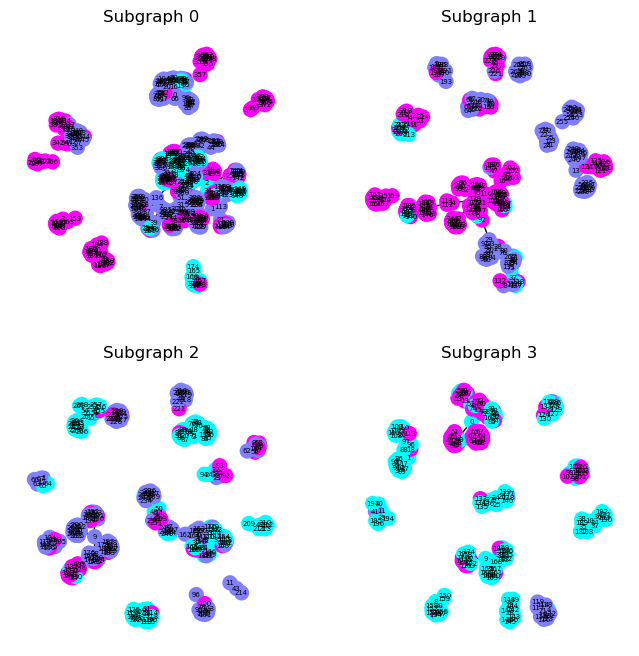

In [3]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')
    
# Plot each subgraph
fig = plt.figure(figsize=(8,8))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221,222,223,224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=True,
                     node_size=100,
                     node_color=subdata.y,
                     cmap="cool",
                     font_size=5
                     )
plt.show()

We created **4 subgraphs** of various sizes. It allows us to process them in parallel and they're easier to fit on a GPU since they're smaller.

The number of neighbors is an important parameter since pruning our graph removes a lot of information. How much, exactly? Well, quite a lot. We can visualize this effect by looking at the **node degrees** (number of neighbors).

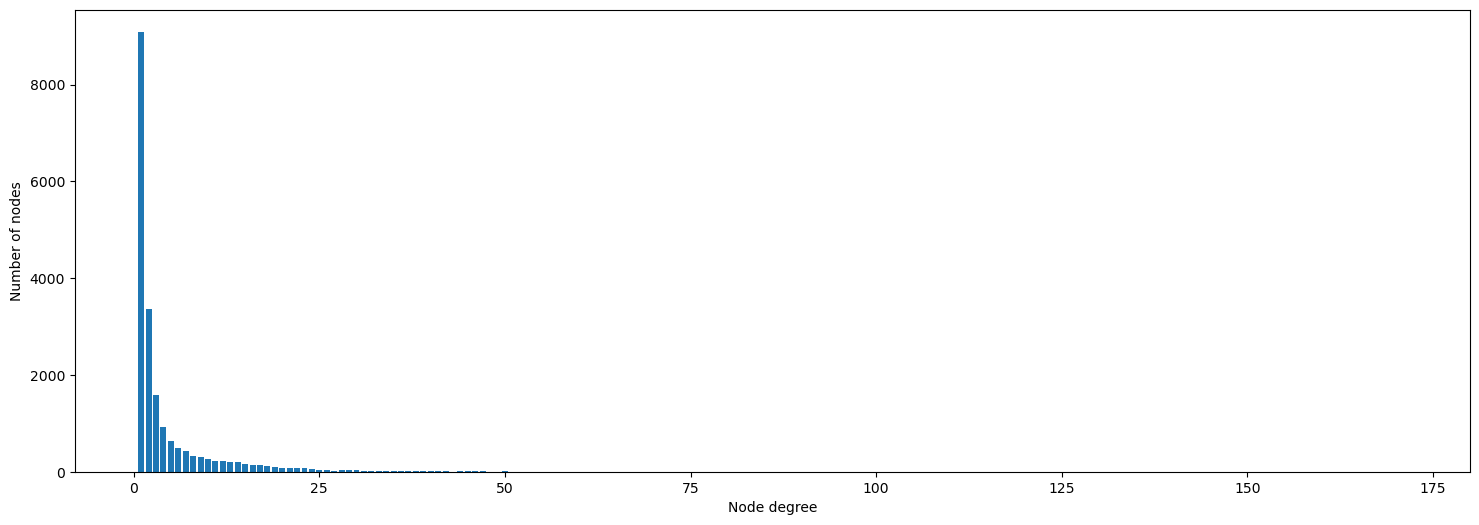

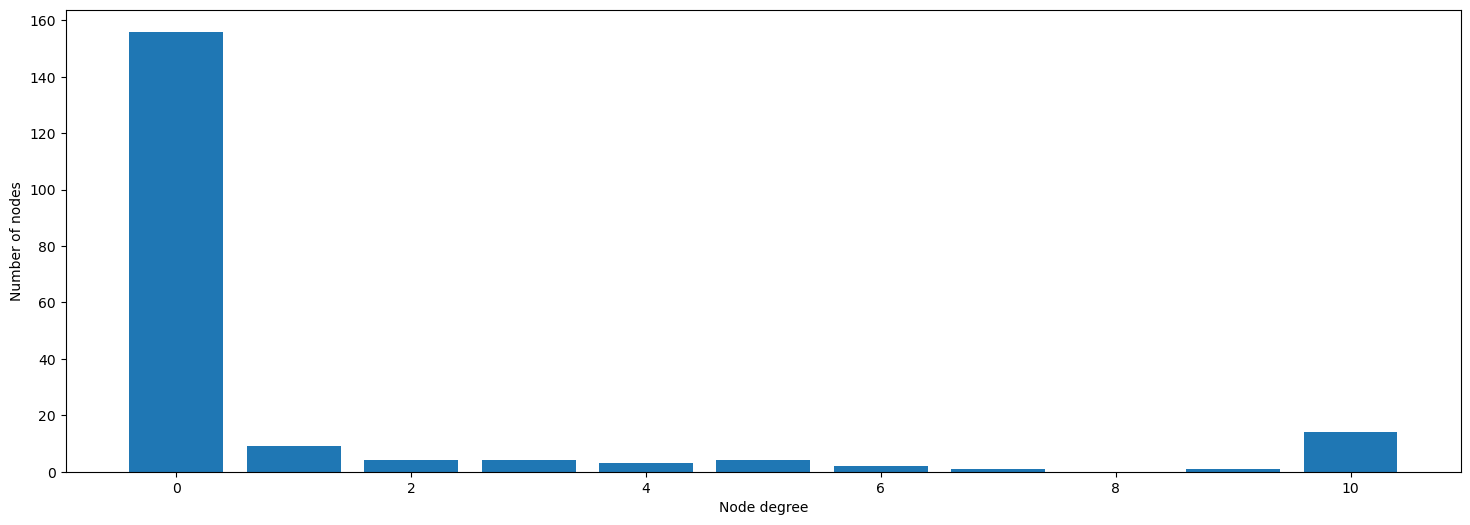

In [4]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data, use_dst=True):
    # choose which side: src or dst
    idx = data.edge_index[1] if use_dst else data.edge_index[0]   # torch tensor

    # compute degree as a torch tensor of shape [num_nodes]
    deg = degree(idx, num_nodes=data.num_nodes).to(torch.long)

    # count occurrences (convert to python ints)
    counts = Counter(deg.cpu().tolist())

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.set_xlabel('Node degree')
    ax.set_ylabel('Number of nodes')
    ax.bar(list(counts.keys()), list(counts.values()))
    plt.show()
    
# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)


In this example, the **maximum node degree** of our subgraphs is 10, which is much lower than the original max value. It's important to remember this tradeoff when talking about GraphSAGE.

PinSAGE **implements another sampling solution using random walks**. It has two main objectives:

1. Sample a **fixed number of neighbors** (like GraphSAGE).
2. Obtain their **relative importance** (important nodes are seen more frequently than others).

This strategy feels a bit like a fast **attention mechanism**. It assigns weights to nodes and increases the relevance of the most popular ones.

## Aggregation

The aggregation process determines how to combine the feature vectores to produce the node embeddings. The original paper presents three ways of aggregating features:

* **Mean** aggregator
* **LSTM** aggregator
* **Pooling** aggregator

The **mean aggregator** is the simplest one. The idea is close to a GCN approach:

1. The hidden features of the target node and it's selected neighbors are averaged ($\tilde{\mathcal{N}}_{i}$).
2. A linear transformation with a weight matrix $W$ is applied.

$$h'_{i} = W \cdot mean_{j\in\tilde{\mathcal{N}}_{i}}(h_{j})$$

The result can then be fed into a non-linear activation function like ReLU.

The **LSTM aggregator** can seem like a weird idea because this architecture is sequential: it assigns an order to our unordered nodes. This is why the authors randomly shuffle them to force the LSTM to only consider the hidden features. It is the best performing technique in their benchmarks.

The **pooling aggregator** feeds each neighbors hidden vector to a feedforward neural network. A max-pooling operation is applied to the result.

## Implementation - GraphSAGE

We can easily implement a GraphSAGE architecture in PyTorch Geometric with the `SAGEConv` layer. This implementation uses two weight matrices instaed of one, like UberEats' version of GraphSAGE:

$$h'_{i} = W_{1}h_{i} + W_{2} \cdot mean_{j\in\mathcal{N}_{i}}(h_{j})$$

Let's create a network with two `SAGEConv` layers:

* The first one will use **ReLU** as the activation function and a **dropout layer**.
* The second one will directly output the **node embeddings**.

As we're dealing with a multi-class classificaiton task, we'll use the cross-entropy loss as out loss function. I also added an L2 regularization of 0.0005 for good measure.

To see the benefits of GraphSAGE, let's compare it with a GCN and a GAT without any sampling.

In [11]:
from torch_geometric.nn.conv import SAGEConv
import torch.nn.functional as F

def accuracy(pred_y, y):
    """Calculate Accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)
        
    def forward(self, x, edge_index, return_hidden=False):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        out = self.sage2(h, edge_index)
        if return_hidden:
            return h, F.log_softmax(out, dim=1)
        return out, F.log_softmax(out, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = self.optimizer
        
        self.train()
        for epoch in range(epochs+1):
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in train_loader:
                optimizer.zero_grad()
                h, out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                                batch.y[batch.train_mask])
                
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                                    batch.y[batch.val_mask])

            # Print metrics every 10 epochs
            if(epoch % 10 == 0):
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                        f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                        f'{val_loss/len(train_loader):.2f} | Val Acc: '
                        f'{val_acc/len(train_loader)*100:.2f}%')

In [20]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 16, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(train_loader, 400)

GraphSAGE(
  (sage1): SAGEConv(500, 16, aggr=mean)
  (sage2): SAGEConv(16, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.300 | Train Acc:  34.32% | Val Loss: 1.11 | Val Acc: 22.50%
Epoch  10 | Train Loss: 0.123 | Train Acc:  86.83% | Val Loss: 0.76 | Val Acc: 67.50%
Epoch  20 | Train Loss: 0.032 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 86.99%
Epoch  30 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 67.36%
Epoch  40 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 0.56 | Val Acc: 71.49%
Epoch  50 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.70 | Val Acc: 76.07%
Epoch  60 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0.43 | Val Acc: 88.75%
Epoch  70 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 0.70 | Val Acc: 72.98%
Epoch  80 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 82.12%
Epoch  90 | Train Loss: 0.006 | Train Acc:  98.53% | Val Loss: 0.58 | Val Acc: 74.11%
Epoch 100 | Train Loss: 0.003 | Train Acc: 100.00

With GraphSAGE, we loop through **batches** (our 4 subgraphs) created by the neighbor sampling process. The way we calculate the accuracy and the validation loss is also different because of that.

The three models obtain similar results in terms of accuracy. We expect the GAT to perform better because its aggregation mechanism is more nuanced, but it's not always the case. The real difference is the training time: GraphSAGE is **88 times** faster than the GAT and 4 times faster than the GCN!

Here lies the true power of GraphSAGE. We do lose a lot of information by pruning our graph with neighbor sampling. The final node embeddings might **not be as good** as what we could get with a GCN or GAT. But this is not the point: GraphSAGE is designed to improve scalability. In turn, it can lead to building larger graphs with improved accuracy.

In [24]:
eval_loader = NeighborLoader(
    data,
    input_nodes=None,          # all nodes
    num_neighbors=[10, 10],
    batch_size=256,
    shuffle=False,
)

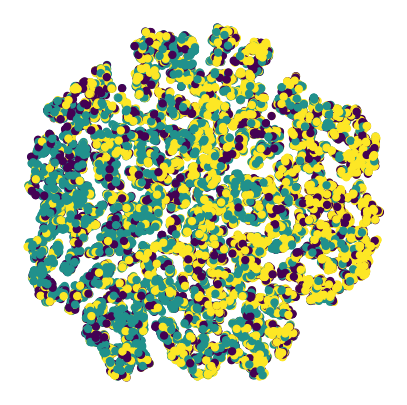

In [25]:
from sklearn.manifold import TSNE

untrained_graphsage = GraphSAGE(dataset.num_features, 16, dataset.num_classes)

untrained_graphsage.eval()
num_nodes = data.num_nodes
hidden_dim = 16  # GraphSAGE hidden dim

# Store sum of embeddings
H = torch.zeros((num_nodes, 3))

# Store how many times each node appears
counts = torch.zeros(num_nodes)
with torch.no_grad():
    for batch in eval_loader:
        h_batch, _ = untrained_graphsage(batch.x, batch.edge_index)   # [num_batch_nodes, hidden_dim]

        global_ids = batch.n_id                         # map to original graph
        H[global_ids] += h_batch
        counts[global_ids] += 1

mask = counts > 0
H[mask] = H[mask] / counts[mask].unsqueeze(1)

# Train TSNE
tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    init='pca',
    perplexity=30,
).fit_transform(H.numpy())

# Plot TSNE
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=25, c=data.y)
plt.show()

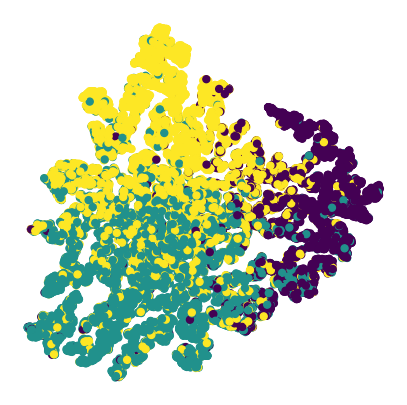

In [26]:
graphsage.eval()

num_nodes = data.num_nodes
hidden_dim = 16

H = torch.zeros((num_nodes, 3), dtype=torch.float32)
counts = torch.zeros(num_nodes, dtype=torch.float32)

with torch.no_grad():
    for batch in eval_loader:  # input_nodes=data.train_mask
        h_batch, _ = graphsage(batch.x, batch.edge_index)  # [B, 16]
        global_ids = batch.n_id

        H[global_ids.cpu()] += h_batch.cpu()
        counts[global_ids.cpu()] += 1

mask = counts > 0
H[mask] /= counts[mask].unsqueeze(1)

# Only plot nodes we actually embedded (train-covered)
Y = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=30)\
        .fit_transform(H[mask].numpy())

plt.figure(figsize=(5, 5))
plt.axis("off")
plt.scatter(Y[:, 0], Y[:, 1], s=25, c=data.y[mask].cpu())
plt.show()
